In [1]:
from ANEMO import ANEMO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.7'

In [2]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [3]:
def FIT(test, x, tau, maxi, latence, start_anti, v_anti, bino):

    model = Model(ANEMO.fct_exponentiel)
    params = Parameters()

    params.add('tau', value=tau[0], min=tau[1], max=tau[2])
    params.add('maxi', value=maxi[0], min=maxi[1], max=maxi[2])
    params.add('latence', value=latence[0], min=latence[1], max=latence[2])
    params.add(
        'start_anti', value=start_anti[0], min=start_anti[1], max=start_anti[2])
    params.add('v_anti', value=v_anti[0], min=v_anti[1], max=v_anti[2])
    params.add('bino', value=bino, vary=False)

    result_deg = model.fit(test, params, x=x, fit_kws={'nan_policy': 'omit'})

    return result_deg

In [4]:
def plot(x, start_anti_fit, v_anti_fit, latence_fit, tau_fit, maxi_fit, bruit):

    np.random.seed(7)
    fig2, axs2 = plt.subplots(3, 1, figsize=(10, 3*(10*1/2)/1.6180))
    fig, axs = plt.subplots(3, 2, figsize=(5*2, (5*3)/1.6180))

    for trial in range(25):
        bino = exp['p'][trial][0][0]
        start_anti_true = param['start_anti'][0][trial]+TargetOn
        v_anti_true = param['v_anti'][0][trial]
        latence_true = param['latence'][0][trial]+TargetOn
        tau_true = param['tau'][0][trial]
        maxi_true = param['maxi'][0][trial]

        test = ANEMO.fct_exponentiel(x, bino, start_anti_true, v_anti_true, latence_true,
                                     tau_true, maxi_true)+np.random.rand(len(x))*bruit
        test = test-np.random.rand(len(x))*bruit
        test[770:820] = np.arange(0, 50, 1)*np.nan

        result_deg = FIT(test, x, tau_fit, maxi_fit, latence_fit, start_anti_fit,
                         v_anti_fit, bino)

        axs[0][0].set_title('start_anti')
        axs[0][1].set_title('v_anti')
        axs[1][0].set_title('latence')
        axs[1][1].set_title('tau')
        axs[2][0].set_title('maxi')

        for a in range(3):
            for b in range(2):
                axs[a][b].set_xlabel('true')
                axs[a][b].set_ylabel('fit')

        axs[0][0].scatter(
            start_anti_true, result_deg.values['start_anti'], c='k', alpha=0.5)
        axs[0][1].scatter(
            v_anti_true, result_deg.values['v_anti'], c='k', alpha=0.5)
        axs[1][0].scatter(
            latence_true, result_deg.values['latence'], c='k', alpha=0.5)
        axs[1][1].scatter(tau_true, result_deg.values['tau'], c='k', alpha=0.5)
        axs[2][0].scatter(
            maxi_true, result_deg.values['maxi'], c='k', alpha=0.5)

        plt.tight_layout()

        if trial < 3:
            axs2[trial].plot(test, c='k', alpha=0.5)
            axs2[trial].plot(result_deg.init_fit, c='k')
            axs2[trial].plot(result_deg.best_fit, c='r')

## Paramêtres ANEMO

In [5]:
x = np.arange(0,1400,1)
TargetOn, StimulusOf = 750, 750-300

In [6]:
def defaut():
    start_anti_fit = [TargetOn-100,StimulusOf-200,TargetOn+75]
    latence_fit = [TargetOn+100, TargetOn+75, len(x)]
    v_anti_fit = [0.,-40.,40.]
    tau_fit = [15.,13.,80.]
    maxi_fit = [15.,1.,40.]
    
    return(start_anti_fit, latence_fit, v_anti_fit, tau_fit, maxi_fit)

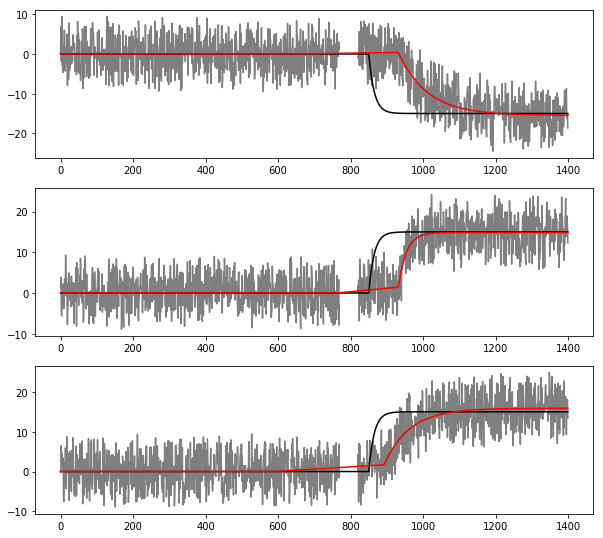

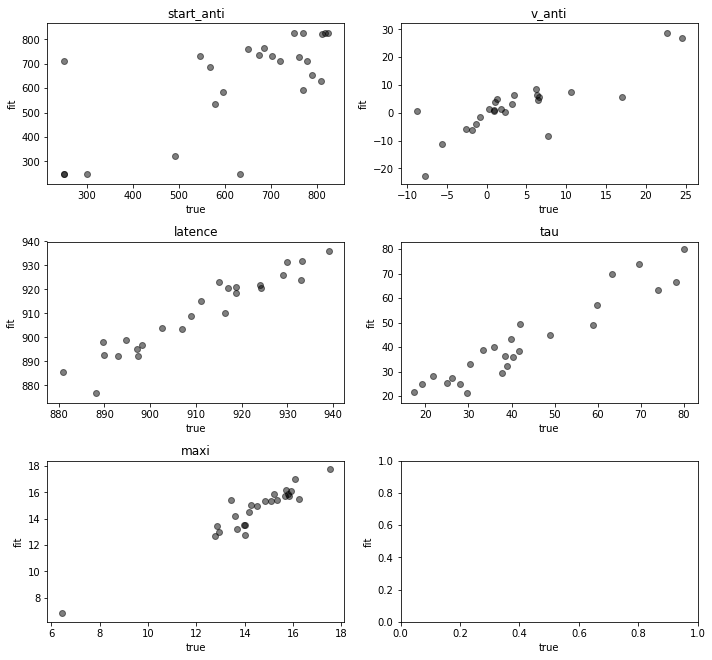

In [7]:
start_anti_fit, latence_fit, v_anti_fit, tau_fit, maxi_fit = defaut()

plot(x, start_anti_fit, v_anti_fit, latence_fit, tau_fit, maxi_fit, bruit=10)


## Changement des paramètres


TODO: voir si ça devient plus robuste avec un 2-step fit


### Maxi

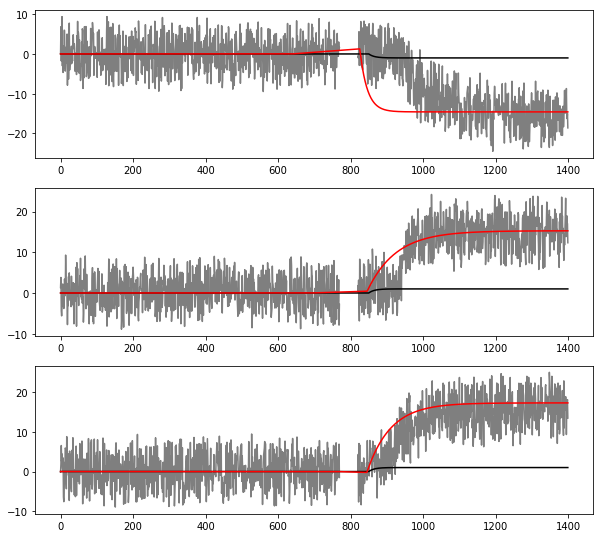

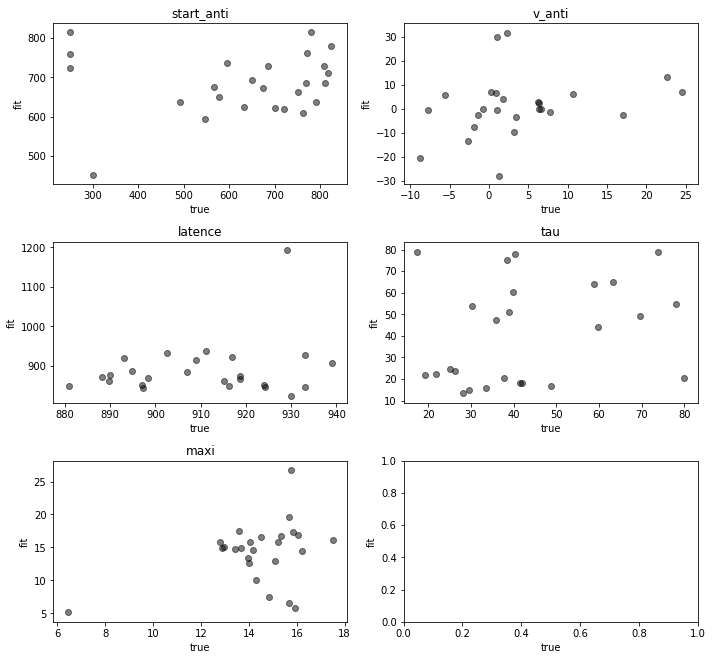

In [8]:
start_anti_fit, latence_fit, v_anti_fit, tau_fit, maxi_fit = defaut()
maxi_fit = [1., 1., 40.]  # [15., 1., 40.]

plot(x, start_anti_fit, v_anti_fit, latence_fit, tau_fit, maxi_fit, bruit=10)

### tau

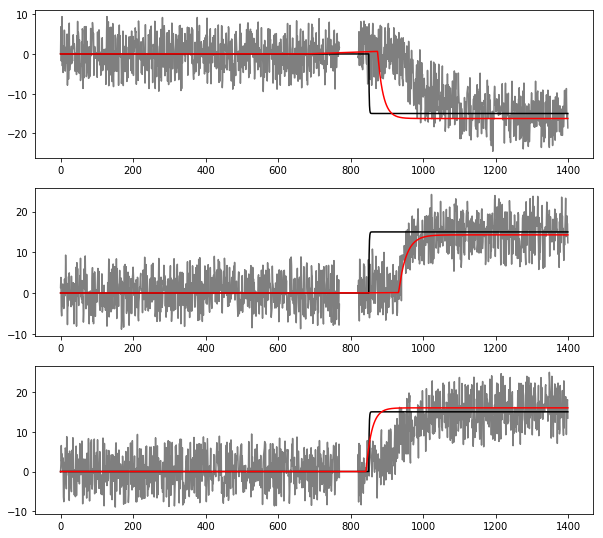

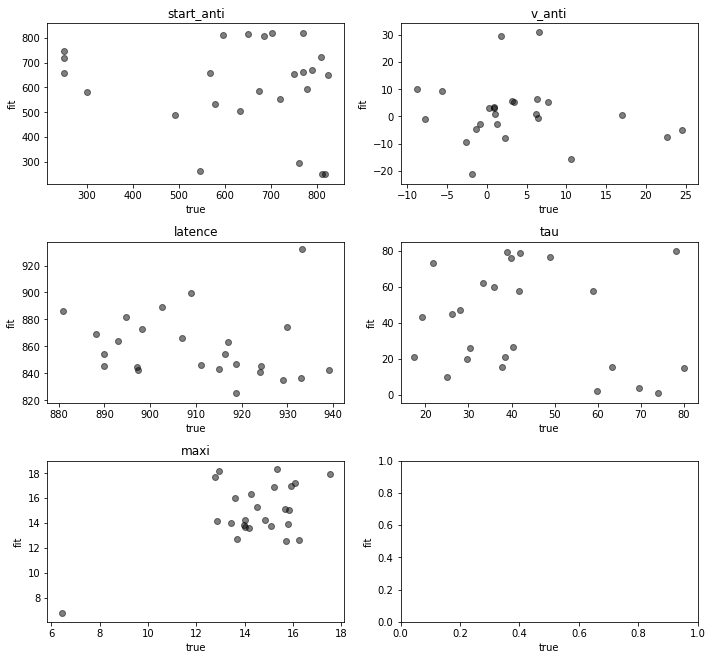

In [9]:
start_anti_fit, latence_fit, v_anti_fit, tau_fit, maxi_fit = defaut()
tau_fit = [1.,1.,80.] # [15.,13.,80.]

plot(x, start_anti_fit, v_anti_fit, latence_fit, tau_fit, maxi_fit, bruit=10)

### v_anti

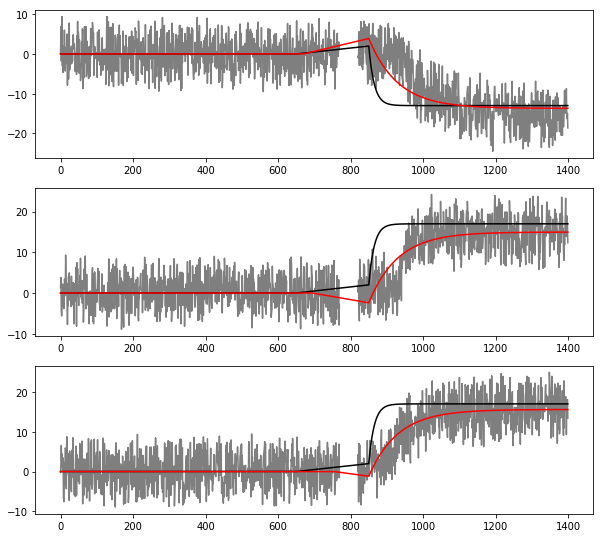

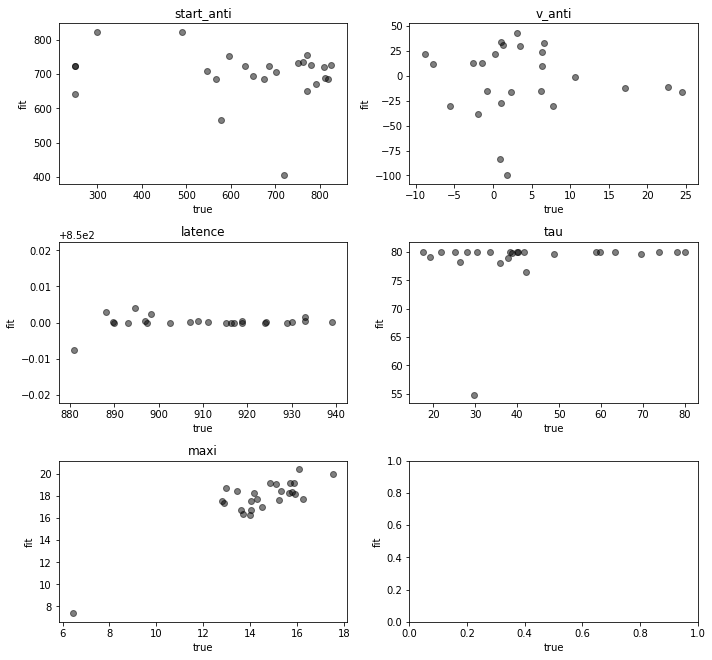

In [10]:
start_anti_fit, latence_fit, v_anti_fit, tau_fit, maxi_fit = defaut()
v_anti_fit = [10.,-100.,100.] # [0.,-40.,40.]

plot(x, start_anti_fit, v_anti_fit, latence_fit, tau_fit, maxi_fit, bruit=10)